# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import os
from dask.distributed import Client

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
import cftime                                     # In case you need to work with time axes
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 12)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

## Accessing ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [5]:
#Saving name of experiments of interest in variables that can be easily referred to
exp = "01deg_jra55v140_iaf_cycle2"
#Name (short name) of variable of interest
varInt = "aice" #sea ice concentration

Optional variables, activate if needed. Note that because times need correction, **the start time is actually one month after the month we are interested in**. See below for explanation.

In [6]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-02-15' for i in range(2000, 2019, 1)]
#End date
etime = [str(i)+'-02-14' for i in range(2001, 2020, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 daily'

## Defining functions

**Accessing ACCESS-OM2-01 outputs**  
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.  
The `getACCESSdata` will achieve the following:  
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified  
- Apply **time corrections** as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required.  The **Southern Ocean** is defined as ocean waters south of 45S.

In [7]:
#Accessing corrected longitude data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp = exp, freq = freq, ses = session, minlon = geolon_t.yt_ocean.values.min(), maxlon = geolon_t.yt_ocean.values.max(),\
                  minlat = geolon_t.xt_ocean.values.min(), maxlat = geolon_t.xt_ocean.values.max()):
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Applying time correction 
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset 
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(yt_ocean = slice(minlon, maxlon))
    return vararray

## Applying functions
A variety of plots showing sea ice area changes in the Southern Ocean will be created below and saved in a folder using years of data shown in the graph as a unique identifier.

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [ ]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = cc.querying.getvar(exp, 'area_t', session, n = 1)
#Accessing ACCESS 0.1deg outputs for the entire time range of interest
SO = getACCESSdata(varInt, stime[0], etime[-1], minlon = -90, maxlon = -50, freq = freq)

## Sea ice seasonality calculations
The code below has been 'translated' from the `calc_ice_season` which is part of the `aceecostats` package developed by Michael Sumner at AAD. This section calculates annual sea ice advance and retreat as defined by Massom et al 2013 [DOI:10.1371/journal.pone.0064756]. If a pixel has at least 15% of sea ice concentration for five consecutive days, sea ice is considered to be advancing at that pixel. Day of retreat is the time when concentration remains below 15% until the end of the year.

In [ ]:
def SeaIceAdvArrays(array, thres = 0.15, ndays = 5):
          
    #Extracting maximum and minimum year information to add to plot titles
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Ensure data is between Feb 15 to Feb 14
    array = array.sel(time = slice(str(MinY)+'-02-15', str(MaxY)+'-02-14'))
    
    ########
    #Sea ice seasonality calculations
    #Calculate timesteps in dataset
    timesteps = len(array.time.values)

    #Identify pixels (or cells) where sea ice concentration values are equal or over the threshold
    #Resulting data array is boolean. If condition is met then a True is recorded, otherwise set to False
    threshold = xr.where(array >= thres, True, False)

    #Creating masks based on time over threshold
    #Add values through time to get total of days with ice cover of at least 15% within a pixel
    rsum = threshold.sum('time')

    #Boolean data arrays produced
    #No sea ice coverage over threshold. If time sums are zero set to True, otherwise set to False
    noIce = xr.where(rsum == 0, True, False)
    #Sea ice over threshold always present. If time sums are the same to timesteps in analysis set to True, otherwise set to False
    alwaysIce = xr.where(rsum == timesteps, True, False)
    
#     #Add masks to threshold data array
#     threshold.coords['noIce'] = (('yt_ocean', 'xt_ocean'), noIce)
#     threshold.coords['alwaysIce'] = (('yt_ocean', 'xt_ocean'), alwaysIce)

    ########
    #Sea ice advance
    #Use cumulative sums based on time. If pixel has sea ice cover below threshold, then cumulative sum is reset to zero
    adv = threshold.cumsum(dim = 'time')-threshold.cumsum(dim = 'time').where(threshold.values == 0).ffill(dim = 'time').fillna(0)
    #Note: ffill adds nan values forward over a specific dimension

    #Find timestep (date) where the minimum consecutive sea ice concentration was first detected for each pixel
    #Change all pixels that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
    advDate = xr.where(adv == ndays, adv, False)
    #Find the time step index where condition above was met. Apply masks of no sea ice over threshold and sea ice always over threshold.
    advDate = advDate.argmax(dim = 'time')
    advDate = advDate.where(noIce == False, np.nan).where(alwaysIce == False, 1)

    ########
    #Sea ice retreat
    #Reverse threshold data array (time wise) - So end date is now the start date and calculate cumulative sum over time
    ret = threshold[::-1].cumsum('time')
    #Change zero values to 9999 so they are ignored in the next step of our calculation
    ret = xr.where(ret == 0, 9999, ret)
    #Find the time step index where sea ice concentration change to above threshold.
    retDate = ret.argmin(dim = 'time')
    #Substract index from total time length
    retDate = timesteps-retDate
    #Apply masks of no sea ice over threshold and sea ice always over threshold.
    retDate = retDate.where(noIce == False, np.nan).where(alwaysIce == False, timesteps)
    
    ########
    #Sea ice duration
    durDays = retDate-advDate
    
    ########
    #Saving files to disk as netcdf
    advDate.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceAdv_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    retDate.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceRet_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    durDays.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceDur_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    
    return (advDate, retDate, durDays)

In [ ]:
for i in np.arange(0, len(stime)):
    array = SO.sel(time = slice(stime[i], etime[i]))
    SeaIceAdvArrays(array)
# # array = SO.sel(time = slice('2000-02-15', '2001-02-14'))
# x, y, z = SeaIceAdvArrays(array)

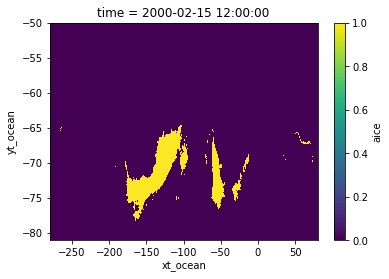

In [23]:
timesteps = len(array.time.values)

#Identify pixels (or cells) where sea ice concentration values are equal or over the threshold
#Resulting data array is boolean. If condition is met then a True is recorded, otherwise set to False
threshold = xr.where(array >= 0.15, True, False)

#Creating masks based on time over threshold
#Add values through time to get total of days with ice cover of at least 15% within a pixel
rsum = threshold.sum('time')

#Boolean data arrays produced
#No sea ice coverage over threshold. If time sums are zero set to True, otherwise set to False
noIce = xr.where(rsum == 0, True, False)
#Sea ice over threshold always present. If time sums are the same to timesteps in analysis set to True, otherwise set to False
alwaysIce = xr.where(rsum == timesteps, True, False)
#Use cumulative sums based on time. If pixel has sea ice cover below threshold, then cumulative sum is reset to zero
adv = threshold.cumsum(dim = 'time')-threshold.cumsum(dim = 'time').where(threshold.values == 0).ffill(dim = 'time').fillna(0)
#Note: ffill adds nan values forward over a specific dimension

#Find timestep (date) where the minimum consecutive sea ice concentration was first detected for each pixel
# #Change all pixels that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
# advDate = xr.where(adv == ndays, adv, False)
# #Find the time step index where condition above was met. Apply masks of no sea ice over threshold and sea ice always over threshold.
# advDate = advDate.argmax(dim = 'time')
# advDate = advDate.where(noIce == False, np.nan).where(alwaysIce == False, 1)
adv[0].plot()

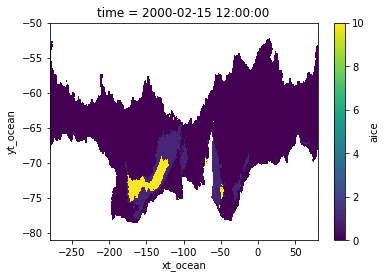

In [26]:
adv.where(noIce == False, np.nan).where(alwaysIce == False, 10)[0].plot()

In [27]:
adv = xr.open_dataset('/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceAdv_2000-2001.nc')
ret = xr.open_dataset('/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceRet_2000-2001.nc')
dur = xr.open_dataset('/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceDur_2000-2001.nc')

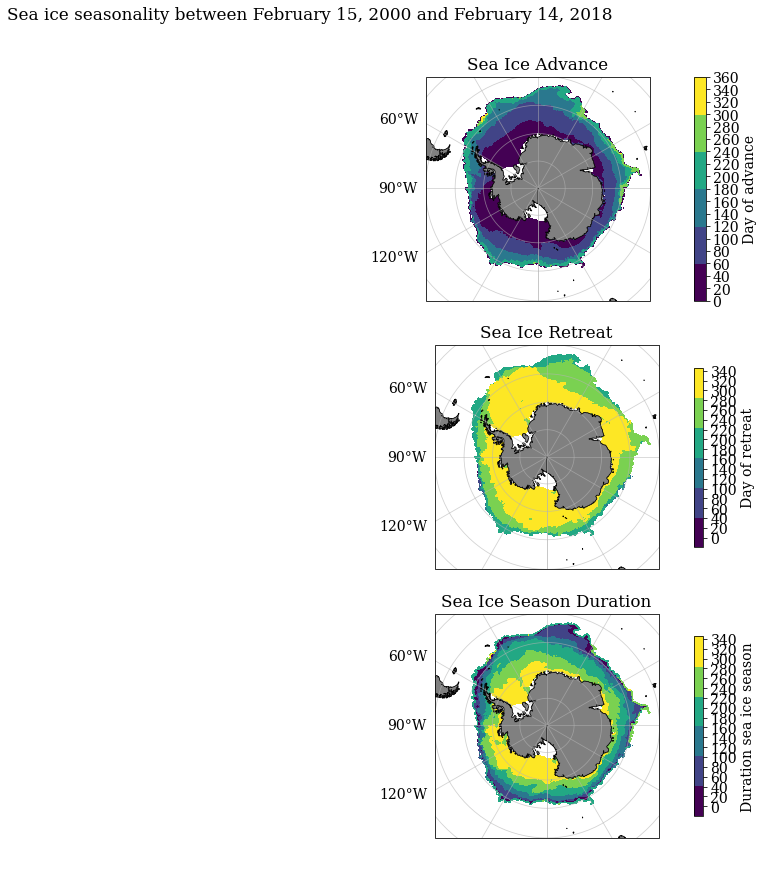

In [32]:
SeaIceAdvMap(SO, adv, ret, dur, palette = 'batlow')
# import re
# filenames = os.listdir('/g/data/v45/la6889/Calculations/SeaIceSeasonality/')
# # p = re.compile(r'.*Adv_(\d{4})-(\d{4}).nc')
# for i in filenames:
#     a = re.match(r'.*Adv_(\d{4})-(\d{4}).nc', i)
# a.groupdict()
# adv.aice.plot()

In [31]:
def SeaIceAdvMap(array, adv, ret, dur, ndays = 5, **colPal):
    '''
    Additional arguments include: palette
    thres = minimum sea ice concentration to be considered in sea ice seasonality calculations
    ndays = minimum number of consecutive days above threshold to be considered as advancing
    '''
    
    #######################################################
    #Colormap settings
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            from matplotlib.colors import ListedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map_ret = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
            pal_map_adv = ListedColormap(cm_data[::-1])
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map_ret = colPal['palette']
            pal_map_adv = colPal['palette'][::-1]
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map_adv = cm.cm.ice
        pal_map_ret = cm.cm.ice[::-1]
    
    
    ####################################################### 
    #Calculate timesteps in dataset
    timesteps = len(array.time.values)
    
    #######################################################
    #Plotting maps
        
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14
    
    #Extracting maximum and minimum year information to add to plot titles
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
        
    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
    
    #Define the contour lines to be shown in the graph. From 1 to length of timesteps+1 and increasing by 1
    levels = np.arange(0, timesteps+1, 1)

    #Colourbar tick labels
    cbar_ticks = [int(i) for i in np.arange(0, timesteps+1, 20)]
        
    #Create composite figure - left panel (axes: 0,0) will show sea ice advance and right panel (axes: 0,1) will show sea ice retreat
    fig, axes = plt.subplots(3, figsize = (16, 14), subplot_kw = dict(projection = projection))
    
    #Plot advancing sea ice day
    p_adv = adv.aice.plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[0], extend = 'neither',
                  #Setting color palette and contour levels
                  add_colorbar = False, #levels = levels, cmap = pal_map_adv, 
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    
    #Plot retreating sea ice day
    p_ret = ret.aice.plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[1], vmin = 1,
                  #Setting color palette and contour levels
#                   cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
        
    #Plot sea ice duration
    p_dur = dur.aice.plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[2], vmin = 1,
                  #Setting color palette and contour levels
#                   cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
    axes[0].set_title('Sea Ice Advance', y = 1.01)
    axes[1].set_title('Sea Ice Retreat', y = 1.01)
    axes[2].set_title('Sea Ice Season Duration', y = 1.01)

    #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
    cb_adv = fig.colorbar(p_adv, ax = axes[0])
    #Set title for colourbar
    cb_adv.ax.set_ylabel('Day of advance')
    #Setting colourbar ticks and labels
    cb_adv.set_ticks(cbar_ticks)
    cb_adv.set_ticklabels(cbar_ticks)
    
    #Set colourbar to be horizontal, 50% its original size and a distance equal to 9% of total figure area from the plot
    cb_ret = fig.colorbar(p_ret, ax = axes[1], shrink = 0.8, pad = 0.04)
    #Set title for colourbar
    cb_ret.ax.set_ylabel('Day of retreat')
    #Setting colourbar ticks and labels
    cb_ret.set_ticks(cbar_ticks)
    cb_ret.set_ticklabels(cbar_ticks)
    
    #Set colourbar to be horizontal, 50% its original size and a distance equal to 9% of total figure area from the plot
    cb_dur = fig.colorbar(p_dur, ax = axes[2], shrink = 0.8, pad = 0.04)
    #Set title for colourbar
    cb_dur.ax.set_ylabel('Duration sea ice season')
    #Setting colourbar ticks and labels
    cb_dur.set_ticks(cbar_ticks)
    cb_dur.set_ticklabels(cbar_ticks)

    #Changing other parameters
    for ax in axes.flat:
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.ylabels_left = True
        if ax != 3:
            gl.xlabels_bottom = False
#         ax.rowNum == 1
        elif ax == 3:
            gl.xlabels_bottom = True

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    fig.suptitle('Sea ice seasonality between February 15, ' + str(MinY) + ' and February 14, '+ str(MaxY), y = 0.95, x = 0.45)

    #Decrease white space between each row of plots
    plt.subplots_adjust(wspace = 0.1)
        
    #Automatically saving figures to local folder
#     plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/SeaIceSeasonality', ('MapSeaIceSeasonal' + str(MinY) + '-' + str(MaxY) + '.png')), dpi = 300)